In this notebook, I plot and analyse adiabats' transition dipole moments and other characteristics. The X-SH adiabats' transition dipole moments were obtained by splitting the adiabats into their diabatic contributions, and then approximating the transition dipole moments of each diabat with a sum of the excited molecule's TRESP charges, weighted by their atomic positions.

By calculating the transition dipole moment for every adiabat of H(R) for a pot of 1000 different geometries, I can bin these into different energy brackets, and obtain a spectrum by plotting the average transition dipole of each bin against the bin energy. The adiabats were expressed relative to the energy of the neutral ground state minimum energy geomtry, using the PDI S1 excitation energy one can obtain via TD-DFT.

I then analyse this spectrum further to figure out what types of adiabats are most optically acessible, how a pulse can be used to 'excite' the relevant adiabats, and how the thermally averaged case (1000 geoemtries) compares to plotting the stick spectrum you obtain from just getting the 0K crystal structure's transition dipoles.

This notebook was originally a copy of what I use for T6-PDI NatComm project. I made a copy and moved the 2nd project's files to a new dir to make everything neater.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '/scratch/fivanovic/X-SH/T6-PDI/production_runs/analysis_scripts')
import file_parsers

import scipy.sparse
import scipy.sparse.linalg
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

In [65]:
def coulomb_interaction(distance, epsilon_r):

    epsilon_0 = 8.8541878188e-12
    elementary_charge = 1.602176634e-19

    distance = distance*1e-10

    interaction = -elementary_charge**2/(4*np.pi*epsilon_0*epsilon_r*distance)

    return interaction

In [66]:
def gaussian_broadening(nom,  adiabat_dipoles, eigenvalues, SIGMA):
    '''
    A function given to me by Samuele, which convolutes your transition dipoles with a guassian of width SIGMA, which acts to
    smoothen the spectrum, and perhaps can be said to account for the energy uncertainty associated with the finite lifetime of the 
    excited state.
    '''
    total_dipole = np.sum(adiabat_dipoles)
    AB0 = []
    for iom in nom:
        BROAD_ABS=0.0
        for st in range(len(eigenvalues)):
            BROAD_ABS=BROAD_ABS+adiabat_dipoles[st]*eigenvalues[st]*np.exp(-((iom-eigenvalues[st])**2)/(SIGMA*SIGMA*2.0))
        BROAD_ABS=BROAD_ABS/(len(eigenvalues)*total_dipole) # Spano definition
        AB0.append(BROAD_ABS)
    return AB0

In [67]:
def convert_meV_to_nm(meV_array):

    nm_list = []
    for element in meV_array:

        element = (element/1000)*1.602176634e-19
        element = element/(6.62607015e-34*3e8)
        element = (1/element)*1e9

        nm_list.append(element)

    nm_array = np.array(nm_list)
    return nm_array

In [68]:
def convert_nm_to_meV(nm_array):

    meV_list = []
    for element in nm_array:

        element = (1/element)/1e9
        element = element*(6.62607015e-34*3e8)
        element = element*1000*1.602176634e-19

        meV_list.append(element)

    meV_array = np.array(meV_list)
    return meV_array

In [69]:
simulation = 'physopt_shortchain_Eb190_recomb'
file_keyword = 'physopt_shortchain_recomb'

epsilon_r = 3.5 #relative permittivity of coulombic interaction

neutral_to_CT_excitation = 2350 #excitation energy of single gas-phase PDI minus XT-CT offset, used to get exciton binding energy. 400 meV taken 
#off gas-phase S1 energy to get iCT excitation in order to preserve XT-CT offset magnitude (~400meV). I use this even when I include recombination 
#even though using the TD-DFT GS-iCT excitation is more accurate, because I want to keep the XT energy relative to GS consistent with what we used
#in the NatComm project.

#neutral_to_CT_recomb = 2430 #excitation energy when neutral GS is explcitly included and I use the XT and iCT
#diabatic energies from TD-DFT + MS-FED-FCD calcs, so exciton S1 = 2.82 eV and S_iCT = 2.43 eV. XT-CT offset is the same but the vertical shift to relate 
#CT and XT to the nuetral GS is slightly different as the S1 now refers to an exciton in a 6T-PDI dimer, not a gas phase exciton

In [70]:
transition_dipole_array = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI-proj2/transition_dipoles/{simulation}/transition_dipoles_rel-to-neutral-{file_keyword}.txt')
XT_character_array = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI-proj2/transition_dipoles/{simulation}/eigen_characters_rel-to-neutral-{file_keyword}.txt') #this file either called eigen_characters or XT_characters
#loading in arrays of all geometries' adiabat energies, transition dipoles and XT-characters

transition_dipole_array[1] = transition_dipole_array[1]*27211.396641307998
XT_character_array[-1] = XT_character_array[-1]*27211.396641307998
#converting energy rows from Hartree to meV

transition_dipoles = transition_dipole_array[:-1]
eigen_energies = transition_dipole_array[-1]

eigen_energies = np.array(sorted(eigen_energies))

excitonic_adiabat_indices = np.where(XT_character_array[0] > 0.95)[0]
#getting the indices of all adiabats which are dominated by XT-states
XT_adiabat_array = XT_character_array[:, excitonic_adiabat_indices]
XT_adiabat_dipoles = transition_dipole_array[:, excitonic_adiabat_indices]
#using these indices to separate out the excitonic adiabats' XT-characters and transition dipoles

#then doing the same for CT-dominated adiabats (p_CT > 0.95), and the adiabats that fall in-between these two categories

CT_adiabat_indices = np.where(XT_character_array[0] < 0.05)[0]
CT_adiabat_array = XT_character_array[:, CT_adiabat_indices]
CT_adiabat_dipoles = transition_dipole_array[:, CT_adiabat_indices]

hybrid_indices = np.where(XT_character_array[0] > 0.05)[0]
hybrid_adiabat_array = XT_character_array[:, hybrid_indices]
hybrid_dipoles = transition_dipole_array[:, hybrid_indices]

#getting indices of iCT and non-interfacial CT eigenstates, comment out for systems for which I haven't yet calculated this
#iCT_adiabat_indices = np.where(XT_character_array[2] > 0.8)[0]
#iCT_adiabat_array = XT_character_array[:, iCT_adiabat_indices]

real_hybrid_indices = np.where(hybrid_adiabat_array[0] < 0.95)[0]
hybrid_dipoles = hybrid_dipoles[:, real_hybrid_indices]
hybrid_adiabat_array = hybrid_adiabat_array[:, real_hybrid_indices]

number_bins = 500 #No. bins controls how finely the eigenstate energies are divided when the binned averages are calculated
total_number_eigenstates = len(eigen_energies)

#binning the neutral-reference dipoles and energies

energy_width = eigen_energies[-1] - eigen_energies[0]
energy_bins = np.arange(eigen_energies[0], eigen_energies[-1], energy_width/number_bins)
#splitting total energy spectrum into  number_bins, and then doing the same for the energy spectra of CT-like, XT-like and hybrid adiabats

XT_energy_width = XT_adiabat_dipoles[-1][-1] - XT_adiabat_dipoles[-1][0]
XT_energy_bins = np.arange(XT_adiabat_dipoles[-1][0], XT_adiabat_dipoles[-1][-1], XT_energy_width/number_bins)

CT_energy_width = CT_adiabat_dipoles[-1][-1] - CT_adiabat_dipoles[-1][0]
CT_energy_bins = np.arange(CT_adiabat_dipoles[1][0], CT_adiabat_dipoles[1][-1], CT_energy_width/number_bins)

hybrid_energy_width = hybrid_dipoles[-1][-1] - hybrid_dipoles[-1][0]
hybrid_energy_bins = np.arange(hybrid_dipoles[-1][0], hybrid_dipoles[-1][-1], hybrid_energy_width/number_bins)

total_bin_indices = np.digitize(eigen_energies, energy_bins)
XT_bin_indices = np.digitize(XT_adiabat_dipoles[-1], XT_energy_bins)
CT_bin_indices = np.digitize(CT_adiabat_dipoles[-1], CT_energy_bins)
hybrid_bin_indices = np.digitize(hybrid_dipoles[-1], hybrid_energy_bins)
#using the digitze function to get the indices of the adiabats whose energies fall into a specific bin

bin_index_list = [total_bin_indices, XT_bin_indices, CT_bin_indices, hybrid_bin_indices]
bin_list = [energy_bins, XT_energy_bins, CT_energy_bins, hybrid_energy_bins]
dipole_array_list = [transition_dipole_array, XT_adiabat_dipoles, CT_adiabat_dipoles, hybrid_dipoles]
adiabat_character_list = [XT_character_array, XT_adiabat_array, CT_adiabat_array, hybrid_adiabat_array]
#grouping different bits of info into 3 lists, where the info of a certain adiabat type has the same index

info_list = zip(bin_index_list, bin_list, dipole_array_list, adiabat_character_list)
#then zipping this so we just need one index to refer to access the info

active_bin_list = []
average_dipole_list = []
normalised_average_dipole_list = []
average_xt_list = []
average_ict_list = []
average_nict_list = []
average_css_list = []
DOS_list = []

for state_type in info_list:

    bin_indices = state_type[0]
    energy_bins = state_type[1]
    dipole_array = state_type[2]
    character_array = state_type[3]

    averaged_bin_dipoles = []
    averaged_bin_xt = []
    averaged_bin_ict = []
    averaged_bin_nict = []
    averaged_bin_css = []
    active_bin_energies = []
    density_of_states = []

    for index in range(len(energy_bins)):

        binned_TD_indices = np.where(bin_indices == index + 1)[0]

        bin_density = len(binned_TD_indices)/len(dipole_array[0])
        density_of_states.append(bin_density)

        binned_dipole_array = dipole_array[0, binned_TD_indices]
        #getting the indices of the energies that fall into bin 'index+1', then using this to get the corresponding transition dipoles inside this bin

        binned_xt_array = character_array[0, binned_TD_indices]
        binned_ict_array = character_array[1, binned_TD_indices]
        binned_nict_array = character_array[2, binned_TD_indices]
        binned_css_array = character_array[3, binned_TD_indices]
        #doing the same for the ict, nict and css populations of each eigenstate inside the bin

        if binned_dipole_array.any():

            average_binned_TD_value = np.mean(binned_dipole_array)
            #averaging over the transition dipoles in the bin

            average_xt_pop = np.mean(binned_xt_array)
            average_ict_pop = np.mean(binned_ict_array)
            average_nict_pop = np.mean(binned_nict_array)
            average_css_pop = np.mean(binned_css_array)
            #averaging over electronic populations in the same bin

            averaged_bin_dipoles.append(average_binned_TD_value)
            active_bin_energies.append(energy_bins[index])
            #appending the bin energy and averaged binned transition dipoles to external lists

            averaged_bin_xt.append(average_xt_pop)
            averaged_bin_ict.append(average_ict_pop)
            averaged_bin_nict.append(average_nict_pop)
            averaged_bin_css.append(average_css_pop)

    active_bin_list.append(active_bin_energies)
    average_dipole_list.append(averaged_bin_dipoles)
    DOS_list.append(density_of_states)
    #once this has been done for all bins for a certain adiabat type, append the dipole/bin energy lists to another external list (of lists)
    #then move on to the next adiabat type

    average_xt_list.append(averaged_bin_xt)
    average_ict_list.append(averaged_bin_ict)
    average_nict_list.append(averaged_bin_nict)
    average_css_list.append(averaged_bin_css)

    normalised_avg = [d/sum(averaged_bin_dipoles) for d in averaged_bin_dipoles]
    normalised_average_dipole_list.append(normalised_avg)
    #compute the normalised average transition dipoles to use if you want

Text(0, 0.5, 'Squared Transition Dipole Moment /D$^2$')

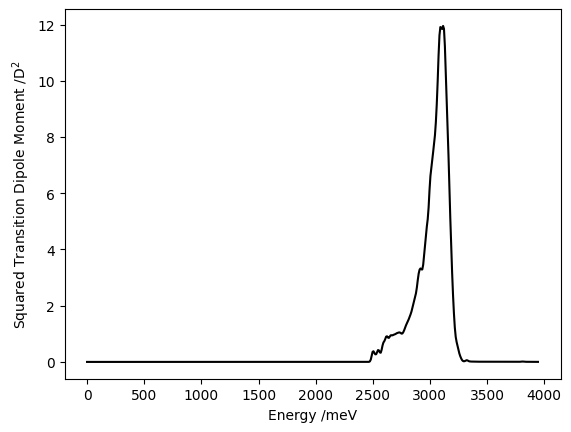

In [71]:
fine_energy_arrays = [np.arange(bin[0], bin[-1], (bin[-1]-bin[0])/len(bin)) for bin in bin_list]
#get energy array from bin energies, such that energies are evenly spaced, to be used in convolution

broadened_spectra = []

for index in range(len(active_bin_list)):

    broadened_thing = gaussian_broadening(fine_energy_arrays[index], average_dipole_list[index], active_bin_list[index], 10)
    #apply gaussian broadening with sigma of 10 meV

    #broadened_thing = [val/sum(broadened_thing) for val in broadened_thing]

    broadened_spectra.append(broadened_thing)

broadened_spectra[0] = [val*7 for val in broadened_spectra[0]]
broadened_spectra[1] = [val*320 for val in broadened_spectra[1]]
broadened_spectra[2] = [val*0.35 for val in broadened_spectra[2]]
broadened_spectra[-1] = [val*125 for val in broadened_spectra[-1]]
#scaling convoluted spectra so that they pass through the underlying data points

#now plotting the spectra corresponding to the different adiabats types, and the one from all adiabats together
    
#plt.scatter(np.array(active_bin_list[0]), average_dipole_list[0], color = 'k', s = 10)
#plt.scatter(active_bin_list[1], average_dipole_list[1], color = 'r', s = 10)
#plt.scatter(active_bin_list[2], average_dipole_list[2], color = 'b', s = 10)
#plt.scatter(active_bin_list[-1], average_dipole_list[-1], color='g', s=10)
plt.plot(fine_energy_arrays[0], broadened_spectra[0], color = 'k', label = 'Total')
#plt.plot(fine_energy_arrays[1], broadened_spectra[1], color = 'r', label = 'XT')
#plt.plot(fine_energy_arrays[2], broadened_spectra[2], color = 'b', label = 'CT')
#plt.plot(fine_energy_arrays[-1], broadened_spectra[-1], color = 'g', label = 'H')
plt.xlabel('Energy /meV')
plt.ylabel('Squared Transition Dipole Moment /D$^2$')
#plt.ylim([0.01,1000])
#plt.xlim([2250,4000])
#plt.legend()

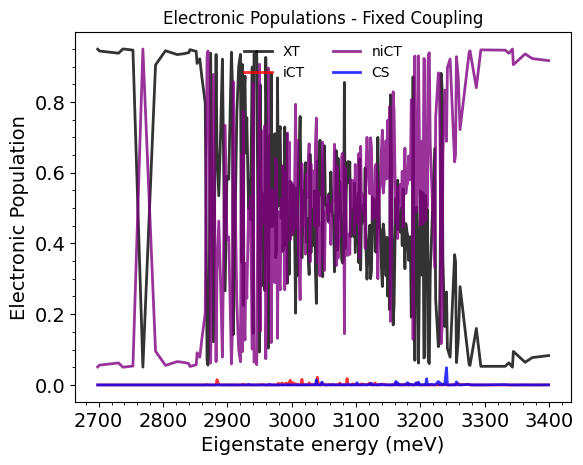

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(active_bin_list[3], average_xt_list[3], color='k', linewidth=2, alpha=0.8, label='XT')
ax.plot(active_bin_list[3], average_ict_list[3], color='red', linewidth=2, alpha=0.8, label='iCT')
ax.plot(active_bin_list[3], average_nict_list[3], color='purple', linewidth=2, alpha=0.8, label='niCT')
ax.plot(active_bin_list[3], average_css_list[3], color='blue', linewidth=2, alpha=0.8, label='CS')
#ax.plot(active_bin_list[3], gaussian_distribution(np.array(active_bin_list[3]), 3090), linewidth=2, color='orange', linestyle='dotted', label='Pulse')
ax.minorticks_on()
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

ax.set_ylabel('Electronic Population', fontsize=14)
ax.set_xlabel('Eigenstate energy (meV)', fontsize=14)
ax.set_title('Electronic Populations - Fixed Coupling')
ax.legend(frameon=False, loc='upper center', ncols=2)

The graph below plots all data points onto a single scatter graph. As expected, it has a similar shape as the convoluted spectrum. The transition dipoles drop of steeply after the peak, but not before, because the optically accessible excitons are grouped up near the top of the different initial geometries' XT-bands. Therefore, the only states after this 'bright' XT group are CT-like states, which we have assumed have no transition dipole moment.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


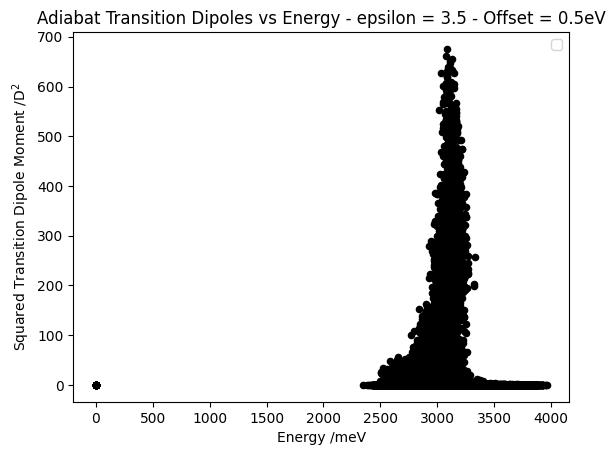

In [73]:
plt.scatter(eigen_energies, transition_dipoles, color = 'k', s = 20)
#plt.scatter(XT_adiabat_dipoles[1], XT_adiabat_dipoles[0], color = 'k', s = 15, label = 'XT')
#plt.scatter(CT_adiabat_dipoles[1], CT_adiabat_dipoles[0], color = 'b', s = 15, label = 'CT')
#plt.scatter(hybrid_dipoles[1], hybrid_dipoles[0], color = 'g', s = 15, label = 'H')
plt.xlabel('Energy /meV')
plt.ylabel('Squared Transition Dipole Moment /D$^2$')
plt.title('Adiabat Transition Dipoles vs Energy - epsilon = 3.5 - Offset = 0.5eV')
plt.legend()

Since we have divided not just the transition dipoles, but also the adiabat energies by adiabat type. We can plot the different adiabat types' DOS profiles with a normalised histogram. The spectrum peak coincides with the upper edge of the XT-like density of states, which confirms that the higher energy states have the highest transition dipoles.

(2400.0, 3400.0)

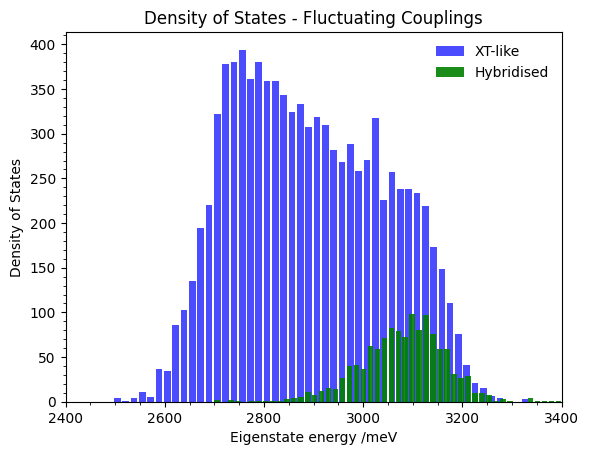

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1)

#plt.hist(CT_adiabat_array[-1], density = True, rwidth=0.7, color = 'r', alpha = 0.5, label = 'CT-like')
ax.hist(XT_adiabat_array[-1], rwidth=0.8, color = 'b', alpha = 0.7, label = 'XT-like', bins=50)
ax.hist(hybrid_dipoles[-1], rwidth=0.8, color = 'g', alpha = 0.9, label = 'Hybridised', bins=50)
ax.minorticks_on()

ax.set_ylabel('Density of States')
ax.set_xlabel('Eigenstate energy /meV')
ax.set_title('Density of States - Fluctuating Couplings')
ax.legend(frameon=False, loc='best')
ax.set_xlim([2400,3400])

We also wanted to account for the probability, given a certain pulse, of a photon with the correct frequency (for energy conservation) coming into contact with the system. This probability can be obtained by assuming you have a gaussian pulse in the frequency domain (a common assumption). Using time-dependent perturbation theory, you can show that the value of this gaussian expression at a given frequency, is equivalent to the probability of that given photon occuring, and is a factor in the total excitation probability.

Therefore, we can choose a gaussian pulse's central frequency and length (in time), that will excite the range of adiabats we're interested in.

We have initially chosen a 10fs pulse (accessible by commercial spectrometers), centred around ~395 nm. We initially want to excite the most optically accessible adiabats, and these pulse settings give good alignment with the peak of the adiabat spectrum.

Text(0.5, 1.0, 'Excitation Probability - GS-CT Included')

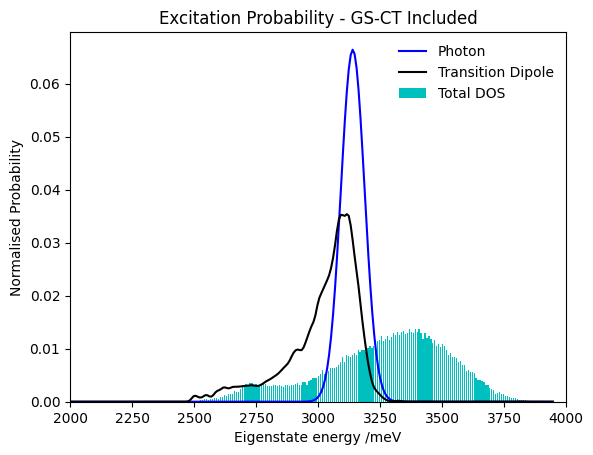

In [75]:
def gaussian_distribution(w, w_0):

    sigma = 47.52 #65.83 previously calculated, but I think this is wrong
    p = np.exp(-(w - w_0)**2/(2*(sigma**2)))
    return p

#you can pretty easily choose the central frequency by eye, since the length is set, but just to be thorough, I have also obtained the 
#central frequency that maximises coverage of the adiabat spectrum by the pulse

#I have done this by selecting the central frequency via least-squares fitting the region where the peak is in the adiabat spectrum

normalised_thermal_spectrum = np.array([val/sum(broadened_spectra[0]) for val in broadened_spectra[0]])
#normalising thermal spectrum plot

pulse_lower_indices = np.where(fine_energy_arrays[0] > (3100 - 2*100))[0]
pulse_inner_eigenvals = fine_energy_arrays[0][pulse_lower_indices]
pulse_inner_dipoles = normalised_thermal_spectrum[pulse_lower_indices]

pulse_upper_indices = np.where(pulse_inner_eigenvals < (3100 + 2*100))[0]
pulse_inner_eigenvals = pulse_inner_eigenvals[pulse_upper_indices]
#slicing the pulse and adiabat arrays such that they only contain regions within the peak of the adiabat spectrum

pulse_inner_dipoles = pulse_inner_dipoles[pulse_upper_indices]*25

optimised_omega0, extra = curve_fit(gaussian_distribution, pulse_inner_eigenvals ,pulse_inner_dipoles, p0 = 3100, bounds = (2900, 3300))
#using curve_fit to pick the central wavelength with the lowest SSR

optimised_pulse = gaussian_distribution(fine_energy_arrays[0], 3140)
optimised_pulse = optimised_pulse/np.sum(optimised_pulse)
#then using this optimal wavelength to plot what our chosen pulse looks like

energy_bins = np.arange(eigen_energies[0], eigen_energies[-1], energy_width/number_bins)

plt.plot(fine_energy_arrays[0], optimised_pulse, color = 'b', label = 'Photon')
plt.plot(fine_energy_arrays[0], normalised_thermal_spectrum, color = 'k', label = 'Transition Dipole')
plt.bar(energy_bins, DOS_list[0], color = 'c', label = 'Total DOS', width = 5)
plt.xlabel('Eigenstate energy /meV')
plt.ylabel('Normalised Probability')
plt.legend(frameon=False)
plt.xlim([2000,4000])
plt.title('Excitation Probability - GS-CT Included')

Using the procedure laid out in XSH_excitation_theory slides, we can randomly select adiabats from our pool of geometries, weighted by their total transition probability. To check that the script works as intended, we can plot the energy distribution of the selected adiabats vs the product of the photon/adiabat probabilities. The adiabat energy distribution should roughly coincide with the probability plot.

I have also plotted the energy distribution of the adiabats selected when X-SH was initialised in the middle exciton diabat. The distribution is different as expected, as the adiabats here are randomly sampled whilst being weighted by the diabat's projection onto them. And the distribution of this projection does not have to coincide with the probability distribution of excitation.

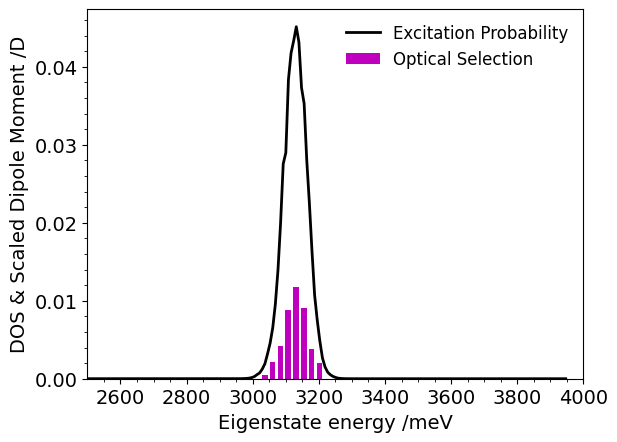

In [76]:
#physopt_initial_XT_characters_lower = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/analysis_arrays/physopt_initial_XT_chars_rel-to-neutral.txt')

#renaming keywords to call initial eigenstate distribution from non-optimised pulse
#simulation = 'physopt_shortchain_Eb190'
#file_keyword = 'physopt-shortchain-Eb190'

physopt_initial_XT_characters = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI-proj2/transition_dipoles/{simulation}/initial_XT_chars_rel-to-neutral-{file_keyword}.txt')
physopt_initial_XT_characters[0] = physopt_initial_XT_characters[0]*27211.396641307998

pulse_spectrum_product = normalised_thermal_spectrum[:]*np.array(DOS_list[0])*optimised_pulse[:]
pulse_spectrum_product = pulse_spectrum_product/np.sum(pulse_spectrum_product)

#plt.hist(physmiddle_initial_XT_characters[0], density = True, color = 'b', alpha = 0.4, rwidth = 0.7, label = 'Middle Diabat')
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(fine_energy_arrays[0][:], pulse_spectrum_product*0.5, color = 'k', label = 'Excitation Probability', linewidth=2)
ax.hist(physopt_initial_XT_characters[0], density = True, color = 'm', alpha = 1, rwidth = 0.7, label = 'Optical Selection', bins=8)
ax.set_ylabel('DOS & Scaled Dipole Moment /D', fontsize = 14)
ax.set_xlabel('Eigenstate energy /meV', fontsize = 14)
ax.minorticks_on()
ax.xaxis.set_tick_params(labelsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_xlim([2500,4000])

ax.legend(fontsize = 12, loc = 'best', frameon=False)

Below is a script to calculate an estimate of the exciton binding energy using the definition outlined in https://doi.org/10.1002/aesr.202100184, where E_b = E_f - E_opt E_f is the energy of the insertion of an uncorrelated electron and hole, which we cannot get relative to the ground state, but can get relative to the iCT diabat, by taking the coulomb interaction to infinity relative to the interaction at the interfacial distance. E_opt is the energy of the lowest optically acessible S1 state. We can get this by taking the lower edge of the full probability spectrum above - by doing this, we assume that the spectrum is made up of entirely excitonic eigenstates; it is also important to note that this spectrum is a result of the pulse wavelength chosen, so this energy corresponds to the lowest accessible state given this exact pulse.

If we express E_opt with respect to the iCT-diabat energy, we can calculate E_b, since both E_f and E_opt will be shifted by the same energy, and their relative values will not change. To do this, I just subtract E_opt by the vertical excitation energy of the diabatic exciton minus the XT-CT offset, which is 2.35eV. The XT/CT forcefields are both expressed wrt the ff-energy at the neutral ground state Eq. configuration, and the 0.4eV offset is that for the Eq. neutral configuration as well. Therefore, the offset plus ff-terms correspond to the XT-diabat energy relative to the iCT-diabat, as a function of geometry. The shift upwards by 2.35ev then expresses both diabats relative to the Eq. neutral geometry, so subtracting by the same number goes back to the initial representation used in X-SH.

Although the band edge is actually an eigenstate, the representation still holds, since the eigenstate energy if just offset + weighted ff-terms relative to Eq. neutral config, and coupling terms, so eigenstate energy is really just geom-dependent XT-CT offset + couplings.

In [77]:
spectrum_peak = np.max(pulse_spectrum_product)
spectrum_peak_index = np.where(pulse_spectrum_product == spectrum_peak)[0]
spectrum_peak_energy = fine_energy_arrays[0][spectrum_peak_index]
lower_signal_indices = np.where(fine_energy_arrays[0] < spectrum_peak_energy)[0]
lower_signal = pulse_spectrum_product[lower_signal_indices]
lower_energies = fine_energy_arrays[0][lower_signal_indices]

#lower_signal_indices = np.where(lower_energies > (spectrum_peak_energy - 200))[0]
#lower_signal_half = lower_signal[lower_signal_indices]
#lower_half_energies = lower_energies[lower_signal_indices]
#S1_abs_edge = lower_half_energies[0]
#S1_edge_dipole = lower_signal_half[0]

abs_edge_index = np.where(lower_signal < spectrum_peak/1000)[0][-1]
S1_abs_edge = lower_energies[abs_edge_index]
S1_abs_edge_signal = lower_signal[abs_edge_index]

interfacial_coulomb = coulomb_interaction(5,epsilon_r)

CT_binding_energy = -interfacial_coulomb*2.2937104486906e+17*1000/0.036749322175665
exciton_binding_energy = CT_binding_energy - (S1_abs_edge - neutral_to_CT_excitation)

print(exciton_binding_energy)
#print((S1_abs_edge - neutral_to_CT_excitation))
#print(CT_binding_energy)

191.42507603648448


In [78]:
print(optimised_omega0)

[3096.23506791]


List of exciton binding energies for different 2D/1D systems at their maxima + tuned values.

Physopt shortchain recomb max: Pulse = 3096 meV, Eb = 231 meV
Physopt shortchain recomb tuned: Pulse = 3140 meV, Eb = 191.4 meV

Physopt shortchain max: Pulse = 3099 meV, Eb = 257 meV
Physopt shortchain tuned: Pulse = 3140 meV, Eb = 190 meV

Physopt 2D max: Pulse = 3170 meV, Eb = 160 meV
Physopt 2D tuned Pulse = 3140 meV, Eb = 190 meV

e5 2xCT shortchain max: Pulse = 3120 meV, Eb = -42.7 meV
e5 2xCT shortchain tuned: Pulse = 3150 meV, Eb = -62 meV

e5 2xCT 2D Max: Pulse = 3211 meV, Eb = -135.4 meV
e5 2xCT 2D Tuned: Pulse = 3145 meV, Eb = -62 meV